# TFRecords Audio-Visual Sequence Generator

Author: Maximo Cobos


In [ ]:
# Import necessary standard packages
import tensorflow as tf
import numpy as np
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip, AudioFileClip
from gammatone.gtgram import gtgram

# Note: If Tensorflow has problems converting tensors to numpy arrays, try executing:
#tf.compat.v1.enable_eager_execution()
#https://stackoverflow.com/questions/34097281/convert-a-tensor-to-numpy-array-in-tensorflow

## Input Data

Specify path to folder containing the video dataset and the output path for the tfrecords:

In [ ]:
# Video Dataset folder
video_main_dir = '.\\dataset\\video'
video_root_path = Path(video_main_dir)

# Audio Dataset folder
audio_main_dir = '.\\.\\dataset\\audio'
audio_root_path = Path(audio_main_dir)

# TFRecords output
output_dir = '.\\tfrecords_gamma'
output_path = Path(output_dir)

## File Processing

- Airport - airport
- Indoor shopping mall - shopping_mall
- Metro station - metro_station
- Pedestrian street - street_pedestrian
- Public square - public_square
- Street with medium level of traffic - street_traffic
- Travelling by a tram - tram
- Travelling by a bus - bus
- Travelling by an underground metro - metro
- Urban park - park



In [ ]:
def get_label(filepath):
    '''Receives a path to a video and returns its label
    '''
    scn_dict = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 
                'street_pedestrian': 3, 'public_square': 4, 'street_traffic': 5,
                'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    
    fileid = Path(filepath).name
    scn_id = fileid.split('-')[0]
    label = scn_dict[scn_id]
    return label

In [ ]:
def get_samples_from_video_gamma(file_path):

    file_path = Path(file_path)
    print('Processing file: {}'.format(file_path.name))


    # =============== VIDEO PART ====================

    final_frame_size = (224,224)

    # =============================================
    # Read video with MoviePy
    # =============================================

    clip = VideoFileClip(str(file_path))       
    if clip.rotation in (90, 270):  # if vertical video
        clip = clip.resize(clip.size[::-1])
        clip.rotation = 0
    w = clip.w
    h = clip.h

    # Iterate over all frames at fps = 5 (enough for video) and resize
    frames = [cv2.resize(frame, final_frame_size) for frame in clip.iter_frames(fps=5)]
    frames = frames[:50]
    Nframes = len(frames)

    # =============== AUDIO PART ====================
    audiopath = audio_root_path / file_path.name
    audiopath = audiopath.with_suffix(".wav")

    # Read audio (resample to 44100)
    audioclip = AudioFileClip(str(audiopath))      
    final_fs = 44100
    audio = audioclip.to_soundarray(fps=final_fs, nbytes=2)
    numsamples = np.shape(audio)[0]

    # Normalize audio channels
    audio = audio/(np.max(audio)-np.min(audio))

    # Compute gammatone
    win_len = 0.04
    hop_len = 0.02
    n_channels = 64
    S_l = gtgram(audio[:,0], final_fs, win_len, hop_len, n_channels, 0)
    S_db_l = np.flipud(20 * np.log10(S_l))
    S_r = gtgram(audio[:,1], final_fs, win_len, hop_len, n_channels, 0)
    S_db_r = np.flipud(20 * np.log10(S_r))
    S_d = gtgram(audio[:,0]-audio[:,1], final_fs, win_len, hop_len, n_channels, 0)
    S_db_d = np.flipud(20 * np.log10(S_d))
    
    S_db_l = np.hstack((S_db_l, S_db_l[:,-1:]))
    S_db_r = np.hstack((S_db_r, S_db_r[:,-1:]))
    S_db_d = np.hstack((S_db_d, S_db_d[:,-1:]))

    S_db_total = np.stack((S_db_l, S_db_r, S_db_d), axis=2)
    #S_db_total = np.swapaxes(S_db_total, 0, 1)
    S_db_total = np.ravel(S_db_total)
    
    #audio_frames = [f for f in S_db_total] 
    audio_frames = S_db_total

    # =============== LABELS ====================
    label = get_label(str(file_path))
    label_list = [label]*Nframes #Repeat label for each frame

    
    return frames, audio_frames, label_list

## TF Records Writing and Parsing Functions

In [ ]:
# create an audio frame-sequence where each entry is an audio frame of bytes
def audioframe_sequence_bytes(audio_frames):
    """this function takes a list of frames and returns the list in bytes"""
    audio_bytes_list = []
    for audio in audio_frames:
        audio_bytes = audio.tobytes()
        audio_bytes = tf.train.Feature(bytes_list=tf.train.BytesList(value=[audio_bytes]))
        audio_bytes_list.append(audio_bytes)

    return audio_bytes_list

def audioframe_sequence_floats(audio_frames):
    """this function takes a list of audio frames and returns the list in floats"""
    audio_float_list = []
    for audio in audio_frames:    
        audio_float = tf.train.Feature(float_list=tf.train.FloatList(value=[audio]))
        audio_float_list.append(audio_float)
    return audio_float_list

# create a video frame-sequence where each entry is a video frame of bytes
def videoframe_sequence(video_frames):
    """this function takes a list of frames and returns the list in bytes"""
    image_bytes_list = []
    for image in video_frames:
        image_bytes = image.tobytes()
        image_bytes = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
        image_bytes_list.append(image_bytes)
    return image_bytes_list

def label_sequence(label_list):
    """this function takes a list of labels and returns the list in int64"""
    label_int_list = []
    frame_int_list = []
    for i,label in enumerate(label_list):
        label_int = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        label_int_list.append(label_int)
        frame_int = tf.train.Feature(int64_list=tf.train.Int64List(value=[i]))
        frame_int_list.append(frame_int)

    return label_int_list, frame_int_list

In [ ]:
def generate_tfrecord_sequence(output_file, video_frames, audio_frames, label_list):
    """this function takes a sequence of video and audio frames and writes a TFRecords file"""
    
    # Open TFRecords file
    writer = tf.io.TFRecordWriter(output_file)
    
    # Sequence information
    frames_length = len(video_frames)

    # Convert sequence of frames and label list to bytes format
    video_bytes_list = videoframe_sequence(video_frames)
    label_int_list, frame_int_list = label_sequence(label_list)
    
    # Sequences
    videoframes = tf.train.FeatureList(feature=video_bytes_list)
    labels = tf.train.FeatureList(feature=label_int_list)
    
    # Features (non lists)
    audioframes = tf.train.Feature(float_list=tf.train.FloatList(value=audio_frames))
    seq_length = tf.train.Feature(int64_list=tf.train.Int64List(value=[frames_length]))

     # create a dictionary corresponding to list features and context info
    sequence_dict = {'VideoFrames': videoframes, 'Labels': labels}    
    context_dict = {'AudioFrames': audioframes, 'length': seq_length}

    sequence_list = tf.train.FeatureLists(feature_list=sequence_dict)
    sequence_context = tf.train.Features(feature=context_dict)
   
    # create sequence example using the created features
    example = tf.train.SequenceExample(context=sequence_context, feature_lists=sequence_list)

    # write example within the TFRecords
    writer.write(example.SerializeToString())

In [ ]:
def parse_sequence(sequence_example, avmode = 'audiovideo'):
    """this function is the sequence parser for the created TFRecords file"""
    
    sequence_features = {'VideoFrames': tf.io.FixedLenSequenceFeature([], dtype=tf.string),                    
                         'Labels': tf.io.FixedLenSequenceFeature([], dtype=tf.int64)}

    context_features = {'AudioFrames': tf.io.FixedLenFeature((96000,), dtype=tf.float32),
                        'length': tf.io.FixedLenFeature([], dtype=tf.int64)}
    context, sequence = tf.io.parse_single_sequence_example(
    sequence_example, context_features=context_features, sequence_features=sequence_features)

    # get features context
    seq_length = tf.cast(context['length'], dtype = tf.int32)   

    # decode video and audio
    video = tf.io.decode_raw(sequence['VideoFrames'], tf.uint8)
    video = tf.reshape(video, shape=(seq_length, 224, 224, 3))
    audio = tf.cast(context['AudioFrames'], tf.float32)
    audio = tf.reshape(audio, shape=(64, 500, 3))
    label = tf.cast(sequence['Labels'], dtype = tf.int32)
    
    if avmode is 'audio':
        return audio, label
    elif avmode is 'video':
        return video, label
    elif avmode is 'audiovideo':
        return video, audio, label

## Generate TFRecords for each file

Create TFrecords file for each audio file

In [ ]:
# List all input files
files = list(video_root_path.rglob('*.mp4'))

for file in files:
    label = get_label(str(file))
    file_id = str(file.stem)
    
    classfolder = output_path / '{}'.format(label)    
    if not os.path.exists(str(classfolder)):
        os.makedirs(str(classfolder))    
        
    outfile_path = classfolder / '{}.tfrecords'.format(file_id)

    if outfile_path.is_file() == False:
        video_frames, audio_frames, label_list =  get_samples_from_video_gamma(str(file))    
        generate_tfrecord_sequence(str(outfile_path), video_frames, audio_frames, label_list)

Processing file: airport-helsinki-3-112.mp4
Processing file: airport-helsinki-3-117.mp4
Processing file: airport-helsinki-3-123.mp4
Processing file: airport-helsinki-3-126.mp4
Processing file: airport-helsinki-3-127.mp4
Processing file: airport-helsinki-3-128.mp4
Processing file: airport-helsinki-3-129.mp4
Processing file: airport-helsinki-3-130.mp4
Processing file: airport-helsinki-3-132.mp4
Processing file: airport-helsinki-3-133.mp4
Processing file: airport-helsinki-3-135.mp4
Processing file: airport-helsinki-3-142.mp4
Processing file: airport-helsinki-3-149.mp4
Processing file: airport-helsinki-3-152.mp4
Processing file: airport-helsinki-3-153.mp4
Processing file: airport-helsinki-3-154.mp4
Processing file: airport-helsinki-3-157.mp4
Processing file: airport-helsinki-3-163.mp4
Processing file: airport-helsinki-3-166.mp4
Processing file: airport-lisbon-1000-40000.mp4
Processing file: airport-lisbon-1000-40073.mp4
Processing file: airport-lisbon-1000-40242.mp4
Processing file: airpor

Processing file: airport-london-205-6199.mp4
Processing file: airport-london-205-6200.mp4
Processing file: airport-london-205-6202.mp4
Processing file: airport-london-205-6203.mp4
Processing file: airport-london-205-6204.mp4
Processing file: airport-london-205-6206.mp4
Processing file: airport-london-205-6207.mp4
Processing file: airport-london-205-6209.mp4
Processing file: airport-london-205-6210.mp4
Processing file: airport-london-205-6211.mp4
Processing file: airport-london-205-6212.mp4
Processing file: airport-london-205-6213.mp4
Processing file: airport-london-205-6214.mp4
Processing file: airport-london-205-6215.mp4
Processing file: airport-london-205-6216.mp4
Processing file: airport-london-205-6217.mp4
Processing file: airport-london-205-6219.mp4
Processing file: airport-london-205-6220.mp4
Processing file: airport-london-205-6222.mp4
Processing file: airport-london-205-6223.mp4
Processing file: airport-london-205-6224.mp4
Processing file: airport-london-205-6225.mp4
Processing

Processing file: airport-lyon-1095-44039.mp4
Processing file: airport-lyon-1095-44064.mp4
Processing file: airport-lyon-1095-44085.mp4
Processing file: airport-lyon-1101-40173.mp4
Processing file: airport-lyon-1101-40386.mp4
Processing file: airport-lyon-1101-40748.mp4
Processing file: airport-lyon-1101-40999.mp4
Processing file: airport-lyon-1101-41172.mp4
Processing file: airport-lyon-1101-41231.mp4
Processing file: airport-lyon-1101-41267.mp4
Processing file: airport-lyon-1101-41351.mp4
Processing file: airport-lyon-1101-41501.mp4
Processing file: airport-lyon-1101-41603.mp4
Processing file: airport-lyon-1101-41703.mp4
Processing file: airport-lyon-1101-41912.mp4
Processing file: airport-lyon-1101-41913.mp4
Processing file: airport-lyon-1101-42334.mp4
Processing file: airport-lyon-1101-42343.mp4
Processing file: airport-lyon-1101-42428.mp4
Processing file: airport-lyon-1101-42602.mp4
Processing file: airport-lyon-1101-42703.mp4
Processing file: airport-lyon-1101-42791.mp4
Processing

Processing file: airport-milan-1108-43786.mp4
Processing file: airport-milan-1108-43915.mp4
Processing file: airport-milan-1108-44084.mp4
Processing file: airport-milan-1172-44103.mp4
Processing file: airport-milan-1172-44126.mp4
Processing file: airport-milan-1172-44205.mp4
Processing file: airport-milan-1172-44215.mp4
Processing file: airport-milan-1172-44376.mp4
Processing file: airport-milan-1172-44409.mp4
Processing file: airport-milan-1172-44524.mp4
Processing file: airport-milan-1172-44533.mp4
Processing file: airport-milan-1172-44567.mp4
Processing file: airport-milan-1172-44586.mp4
Processing file: airport-milan-1172-44624.mp4
Processing file: airport-milan-1172-44661.mp4
Processing file: airport-milan-1172-44687.mp4
Processing file: airport-milan-1172-44762.mp4
Processing file: airport-milan-1172-44768.mp4
Processing file: airport-milan-1172-44819.mp4
Processing file: airport-milan-1172-44887.mp4
Processing file: airport-milan-1172-44925.mp4
Processing file: airport-milan-117

Processing file: airport-paris-9-414.mp4
Processing file: airport-paris-9-415.mp4
Processing file: airport-paris-9-416.mp4
Processing file: airport-prague-1015-40019.mp4
Processing file: airport-prague-1015-40047.mp4
Processing file: airport-prague-1015-40266.mp4
Processing file: airport-prague-1015-40417.mp4
Processing file: airport-prague-1015-40439.mp4
Processing file: airport-prague-1015-40787.mp4
Processing file: airport-prague-1015-40881.mp4
Processing file: airport-prague-1015-40981.mp4
Processing file: airport-prague-1015-40987.mp4
Processing file: airport-prague-1015-41015.mp4
Processing file: airport-prague-1015-41221.mp4
Processing file: airport-prague-1015-41437.mp4
Processing file: airport-prague-1015-41862.mp4
Processing file: airport-prague-1015-41955.mp4
Processing file: airport-prague-1015-42736.mp4
Processing file: airport-prague-1015-42783.mp4
Processing file: airport-prague-1015-42872.mp4
Processing file: airport-prague-1015-43103.mp4
Processing file: airport-prague

Processing file: airport-stockholm-11-478.mp4
Processing file: airport-stockholm-12-479.mp4
Processing file: airport-stockholm-12-480.mp4
Processing file: airport-stockholm-12-481.mp4
Processing file: airport-stockholm-12-482.mp4
Processing file: airport-stockholm-12-483.mp4
Processing file: airport-stockholm-12-484.mp4
Processing file: airport-stockholm-12-485.mp4
Processing file: airport-stockholm-12-486.mp4
Processing file: airport-stockholm-12-487.mp4
Processing file: airport-stockholm-12-488.mp4
Processing file: airport-stockholm-12-489.mp4
Processing file: airport-stockholm-12-490.mp4
Processing file: airport-stockholm-12-491.mp4
Processing file: airport-stockholm-12-492.mp4
Processing file: airport-stockholm-12-493.mp4
Processing file: airport-stockholm-12-494.mp4
Processing file: airport-stockholm-12-495.mp4
Processing file: airport-stockholm-12-496.mp4
Processing file: airport-stockholm-12-497.mp4
Processing file: airport-stockholm-12-498.mp4
Processing file: airport-stockholm

Processing file: bus-barcelona-210-6401.mp4
Processing file: bus-barcelona-210-6402.mp4
Processing file: bus-barcelona-210-6403.mp4
Processing file: bus-barcelona-210-6404.mp4
Processing file: bus-barcelona-210-6405.mp4
Processing file: bus-barcelona-210-6406.mp4
Processing file: bus-barcelona-210-6407.mp4
Processing file: bus-barcelona-210-6408.mp4
Processing file: bus-barcelona-210-6409.mp4
Processing file: bus-barcelona-210-6410.mp4
Processing file: bus-barcelona-210-6411.mp4
Processing file: bus-barcelona-210-6412.mp4
Processing file: bus-barcelona-210-6413.mp4
Processing file: bus-barcelona-210-6414.mp4
Processing file: bus-barcelona-210-6415.mp4
Processing file: bus-barcelona-210-6416.mp4
Processing file: bus-barcelona-210-6417.mp4
Processing file: bus-barcelona-210-6418.mp4
Processing file: bus-barcelona-210-6419.mp4
Processing file: bus-barcelona-210-6420.mp4
Processing file: bus-barcelona-210-6421.mp4
Processing file: bus-barcelona-210-6422.mp4
Processing file: bus-helsinki-18

Processing file: bus-lisbon-1123-40428.mp4
Processing file: bus-lisbon-1123-40729.mp4
Processing file: bus-lisbon-1123-40788.mp4
Processing file: bus-lisbon-1123-40913.mp4
Processing file: bus-lisbon-1123-41222.mp4
Processing file: bus-lisbon-1123-41297.mp4
Processing file: bus-lisbon-1123-41714.mp4
Processing file: bus-lisbon-1123-42197.mp4
Processing file: bus-lisbon-1123-42544.mp4
Processing file: bus-lisbon-1123-42725.mp4
Processing file: bus-lisbon-1123-43119.mp4
Processing file: bus-lisbon-1123-43175.mp4
Processing file: bus-lisbon-1123-43648.mp4
Processing file: bus-lisbon-1128-40285.mp4
Processing file: bus-lisbon-1128-40432.mp4
Processing file: bus-lisbon-1128-40440.mp4
Processing file: bus-lisbon-1128-40587.mp4
Processing file: bus-lisbon-1128-41302.mp4
Processing file: bus-lisbon-1128-41609.mp4
Processing file: bus-lisbon-1128-41773.mp4
Processing file: bus-lisbon-1128-41781.mp4
Processing file: bus-lisbon-1128-42825.mp4
Processing file: bus-lisbon-1128-42861.mp4
Processing 

Processing file: bus-lyon-1159-43352.mp4
Processing file: bus-lyon-1159-43479.mp4
Processing file: bus-lyon-1159-43539.mp4
Processing file: bus-lyon-1159-43767.mp4
Processing file: bus-lyon-1177-44109.mp4
Processing file: bus-lyon-1177-44129.mp4
Processing file: bus-lyon-1177-44159.mp4
Processing file: bus-lyon-1177-44178.mp4
Processing file: bus-lyon-1177-44264.mp4
Processing file: bus-lyon-1177-44268.mp4
Processing file: bus-lyon-1177-44565.mp4
Processing file: bus-lyon-1177-44753.mp4
Processing file: bus-lyon-1177-44874.mp4
Processing file: bus-lyon-1177-45193.mp4
Processing file: bus-lyon-1177-45275.mp4
Processing file: bus-lyon-1177-45494.mp4
Processing file: bus-lyon-1177-45521.mp4
Processing file: bus-lyon-1177-45528.mp4
Processing file: bus-lyon-1177-45598.mp4
Processing file: bus-lyon-1186-44122.mp4
Processing file: bus-lyon-1186-44140.mp4
Processing file: bus-lyon-1186-44336.mp4
Processing file: bus-lyon-1186-44482.mp4
Processing file: bus-lyon-1186-44509.mp4
Processing file:

Processing file: bus-prague-1030-41795.mp4
Processing file: bus-prague-1030-41883.mp4
Processing file: bus-prague-1030-43115.mp4
Processing file: bus-prague-1030-43400.mp4
Processing file: bus-prague-1030-43881.mp4
Processing file: bus-prague-1030-43940.mp4
Processing file: bus-prague-1030-44021.mp4
Processing file: bus-prague-1032-40036.mp4
Processing file: bus-prague-1032-40745.mp4
Processing file: bus-prague-1032-41120.mp4
Processing file: bus-prague-1032-41203.mp4
Processing file: bus-prague-1032-41544.mp4
Processing file: bus-prague-1032-41827.mp4
Processing file: bus-prague-1032-42359.mp4
Processing file: bus-prague-1032-42599.mp4
Processing file: bus-prague-1032-42822.mp4
Processing file: bus-prague-1032-42940.mp4
Processing file: bus-prague-1032-43253.mp4
Processing file: bus-prague-1032-43269.mp4
Processing file: bus-prague-1032-43822.mp4
Processing file: bus-prague-1090-40149.mp4
Processing file: bus-prague-1090-40318.mp4
Processing file: bus-prague-1090-40891.mp4
Processing 

Processing file: bus-stockholm-34-1023.mp4
Processing file: bus-stockholm-34-1024.mp4
Processing file: bus-stockholm-34-1025.mp4
Processing file: bus-stockholm-34-1026.mp4
Processing file: bus-stockholm-34-1027.mp4
Processing file: bus-stockholm-34-1028.mp4
Processing file: bus-stockholm-34-1029.mp4
Processing file: bus-stockholm-34-1030.mp4
Processing file: bus-stockholm-34-1031.mp4
Processing file: bus-stockholm-34-1032.mp4
Processing file: bus-stockholm-34-1033.mp4
Processing file: bus-stockholm-34-1034.mp4
Processing file: bus-stockholm-34-1035.mp4
Processing file: bus-stockholm-34-1036.mp4
Processing file: bus-stockholm-34-1037.mp4
Processing file: bus-stockholm-34-1038.mp4
Processing file: bus-stockholm-34-1039.mp4
Processing file: bus-stockholm-34-1040.mp4
Processing file: bus-stockholm-35-1041.mp4
Processing file: bus-stockholm-35-1042.mp4
Processing file: bus-stockholm-35-1043.mp4
Processing file: bus-stockholm-35-1044.mp4
Processing file: bus-stockholm-35-1045.mp4
Processing 

Processing file: bus-vienna-40-1185.mp4
Processing file: bus-vienna-40-1186.mp4
Processing file: bus-vienna-40-1187.mp4
Processing file: bus-vienna-40-1188.mp4
Processing file: bus-vienna-40-1189.mp4
Processing file: bus-vienna-40-1190.mp4
Processing file: bus-vienna-40-1191.mp4
Processing file: bus-vienna-40-1192.mp4
Processing file: bus-vienna-40-1193.mp4
Processing file: bus-vienna-40-1194.mp4
Processing file: bus-vienna-40-1195.mp4
Processing file: bus-vienna-40-1196.mp4
Processing file: bus-vienna-40-1197.mp4
Processing file: bus-vienna-40-1198.mp4
Processing file: bus-vienna-40-1199.mp4
Processing file: bus-vienna-40-1200.mp4
Processing file: bus-vienna-40-1201.mp4
Processing file: bus-vienna-40-1202.mp4
Processing file: bus-vienna-40-1203.mp4
Processing file: bus-vienna-40-1204.mp4
Processing file: bus-vienna-40-1205.mp4
Processing file: bus-vienna-40-1206.mp4
Processing file: bus-vienna-40-1207.mp4
Processing file: bus-vienna-40-1208.mp4
Processing file: bus-vienna-40-1209.mp4


Processing file: metro-helsinki-43-1318.mp4
Processing file: metro-helsinki-43-1319.mp4
Processing file: metro-helsinki-43-1320.mp4
Processing file: metro-helsinki-43-1321.mp4
Processing file: metro-helsinki-44-1322.mp4
Processing file: metro-helsinki-44-1323.mp4
Processing file: metro-helsinki-44-1324.mp4
Processing file: metro-helsinki-44-1325.mp4
Processing file: metro-helsinki-44-1326.mp4
Processing file: metro-helsinki-44-1327.mp4
Processing file: metro-helsinki-44-1328.mp4
Processing file: metro-helsinki-44-1329.mp4
Processing file: metro-helsinki-44-1330.mp4
Processing file: metro-helsinki-44-1331.mp4
Processing file: metro-helsinki-45-1332.mp4
Processing file: metro-helsinki-45-1333.mp4
Processing file: metro-helsinki-45-1334.mp4
Processing file: metro-helsinki-45-1335.mp4
Processing file: metro-helsinki-45-1336.mp4
Processing file: metro-helsinki-45-1337.mp4
Processing file: metro-helsinki-45-1338.mp4
Processing file: metro-helsinki-45-1339.mp4
Processing file: metro-helsinki-

Processing file: metro-lisbon-1224-44955.mp4
Processing file: metro-lisbon-1224-45017.mp4
Processing file: metro-lisbon-1224-45051.mp4
Processing file: metro-lisbon-1224-45162.mp4
Processing file: metro-lisbon-1224-45308.mp4
Processing file: metro-lisbon-1224-45411.mp4
Processing file: metro-lisbon-1224-45413.mp4
Processing file: metro-lisbon-1224-45524.mp4
Processing file: metro-lisbon-1224-45583.mp4
Processing file: metro-lisbon-1224-45653.mp4
Processing file: metro-lyon-1064-40093.mp4
Processing file: metro-lyon-1064-40109.mp4
Processing file: metro-lyon-1064-40512.mp4
Processing file: metro-lyon-1064-40950.mp4
Processing file: metro-lyon-1064-41207.mp4
Processing file: metro-lyon-1064-41365.mp4
Processing file: metro-lyon-1064-41478.mp4
Processing file: metro-lyon-1064-41584.mp4
Processing file: metro-lyon-1064-41689.mp4
Processing file: metro-lyon-1064-41772.mp4
Processing file: metro-lyon-1064-42173.mp4
Processing file: metro-lyon-1064-42225.mp4
Processing file: metro-lyon-1064-4

Processing file: metro-milan-1062-41981.mp4
Processing file: metro-milan-1062-42131.mp4
Processing file: metro-milan-1062-42153.mp4
Processing file: metro-milan-1062-42195.mp4
Processing file: metro-milan-1062-42287.mp4
Processing file: metro-milan-1062-42503.mp4
Processing file: metro-milan-1062-42718.mp4
Processing file: metro-milan-1062-42749.mp4
Processing file: metro-milan-1062-43335.mp4
Processing file: metro-milan-1062-43365.mp4
Processing file: metro-milan-1062-43589.mp4
Processing file: metro-milan-1062-43614.mp4
Processing file: metro-milan-1062-43784.mp4
Processing file: metro-milan-1141-40385.mp4
Processing file: metro-milan-1141-40569.mp4
Processing file: metro-milan-1141-40656.mp4
Processing file: metro-milan-1141-40730.mp4
Processing file: metro-milan-1141-40883.mp4
Processing file: metro-milan-1141-41157.mp4
Processing file: metro-milan-1141-41339.mp4
Processing file: metro-milan-1141-41540.mp4
Processing file: metro-milan-1141-41610.mp4
Processing file: metro-milan-114

Processing file: metro-prague-1081-42746.mp4
Processing file: metro-prague-1081-42893.mp4
Processing file: metro-prague-1081-43114.mp4
Processing file: metro-prague-1081-43901.mp4
Processing file: metro-prague-1081-43969.mp4
Processing file: metro-prague-1113-40212.mp4
Processing file: metro-prague-1113-42011.mp4
Processing file: metro-prague-1113-42286.mp4
Processing file: metro-prague-1113-42776.mp4
Processing file: metro-prague-1113-42853.mp4
Processing file: metro-prague-1113-43816.mp4
Processing file: metro-prague-1157-40716.mp4
Processing file: metro-prague-1157-40775.mp4
Processing file: metro-prague-1157-41051.mp4
Processing file: metro-prague-1157-41229.mp4
Processing file: metro-prague-1157-41299.mp4
Processing file: metro-prague-1157-41804.mp4
Processing file: metro-prague-1157-41810.mp4
Processing file: metro-prague-1157-41899.mp4
Processing file: metro-prague-1157-42137.mp4
Processing file: metro-prague-1157-42705.mp4
Processing file: metro-prague-1157-42771.mp4
Processing

Processing file: metro-stockholm-57-1686.mp4
Processing file: metro-stockholm-57-1687.mp4
Processing file: metro-stockholm-57-1688.mp4
Processing file: metro-stockholm-57-1689.mp4
Processing file: metro-stockholm-57-1690.mp4
Processing file: metro-stockholm-57-1691.mp4
Processing file: metro-stockholm-57-1692.mp4
Processing file: metro-stockholm-57-1693.mp4
Processing file: metro-stockholm-57-1694.mp4
Processing file: metro-stockholm-57-1695.mp4
Processing file: metro-stockholm-57-1696.mp4
Processing file: metro-stockholm-57-1697.mp4
Processing file: metro-stockholm-57-1698.mp4
Processing file: metro-stockholm-57-1699.mp4
Processing file: metro-stockholm-57-1700.mp4
Processing file: metro-stockholm-57-1701.mp4
Processing file: metro-stockholm-57-1702.mp4
Processing file: metro-stockholm-57-1703.mp4
Processing file: metro-stockholm-57-1704.mp4
Processing file: metro-stockholm-57-1705.mp4
Processing file: metro-stockholm-57-1706.mp4
Processing file: metro-stockholm-57-1707.mp4
Processing

Processing file: metro_station-barcelona-229-6905.mp4
Processing file: metro_station-barcelona-229-6906.mp4
Processing file: metro_station-barcelona-229-6907.mp4
Processing file: metro_station-barcelona-229-6908.mp4
Processing file: metro_station-barcelona-229-6909.mp4
Processing file: metro_station-barcelona-229-6910.mp4
Processing file: metro_station-barcelona-229-6911.mp4
Processing file: metro_station-barcelona-229-6912.mp4
Processing file: metro_station-barcelona-229-6913.mp4
Processing file: metro_station-barcelona-229-6914.mp4
Processing file: metro_station-barcelona-229-6915.mp4
Processing file: metro_station-barcelona-229-6916.mp4
Processing file: metro_station-barcelona-229-6917.mp4
Processing file: metro_station-barcelona-229-6918.mp4
Processing file: metro_station-barcelona-230-6919.mp4
Processing file: metro_station-barcelona-230-6920.mp4
Processing file: metro_station-barcelona-230-6921.mp4
Processing file: metro_station-barcelona-230-6922.mp4
Processing file: metro_stati

Processing file: metro_station-helsinki-232-6973.mp4
Processing file: metro_station-helsinki-232-6974.mp4
Processing file: metro_station-helsinki-232-6975.mp4
Processing file: metro_station-helsinki-232-6976.mp4
Processing file: metro_station-helsinki-232-6977.mp4
Processing file: metro_station-helsinki-232-6978.mp4
Processing file: metro_station-helsinki-232-6979.mp4
Processing file: metro_station-helsinki-232-6980.mp4
Processing file: metro_station-helsinki-232-6981.mp4
Processing file: metro_station-helsinki-232-6982.mp4
Processing file: metro_station-helsinki-232-6983.mp4
Processing file: metro_station-helsinki-232-6984.mp4
Processing file: metro_station-helsinki-232-6985.mp4
Processing file: metro_station-helsinki-232-6986.mp4
Processing file: metro_station-helsinki-232-6987.mp4
Processing file: metro_station-helsinki-232-6988.mp4
Processing file: metro_station-helsinki-64-1910.mp4
Processing file: metro_station-helsinki-64-1911.mp4
Processing file: metro_station-helsinki-64-1912.

Processing file: metro_station-lisbon-1020-40224.mp4
Processing file: metro_station-lisbon-1020-40275.mp4
Processing file: metro_station-lisbon-1020-40321.mp4
Processing file: metro_station-lisbon-1020-40325.mp4
Processing file: metro_station-lisbon-1020-40397.mp4
Processing file: metro_station-lisbon-1020-40592.mp4
Processing file: metro_station-lisbon-1020-40727.mp4
Processing file: metro_station-lisbon-1020-41101.mp4
Processing file: metro_station-lisbon-1020-41284.mp4
Processing file: metro_station-lisbon-1020-41453.mp4
Processing file: metro_station-lisbon-1020-41510.mp4
Processing file: metro_station-lisbon-1020-41574.mp4
Processing file: metro_station-lisbon-1020-41598.mp4
Processing file: metro_station-lisbon-1020-41599.mp4
Processing file: metro_station-lisbon-1020-41724.mp4
Processing file: metro_station-lisbon-1020-41753.mp4
Processing file: metro_station-lisbon-1020-41972.mp4
Processing file: metro_station-lisbon-1020-42283.mp4
Processing file: metro_station-lisbon-1020-424

Processing file: metro_station-london-69-2025.mp4
Processing file: metro_station-london-69-2026.mp4
Processing file: metro_station-london-69-2027.mp4
Processing file: metro_station-london-69-2028.mp4
Processing file: metro_station-london-69-2029.mp4
Processing file: metro_station-london-69-2030.mp4
Processing file: metro_station-london-69-2031.mp4
Processing file: metro_station-london-69-2032.mp4
Processing file: metro_station-london-69-2033.mp4
Processing file: metro_station-london-69-2034.mp4
Processing file: metro_station-london-69-2035.mp4
Processing file: metro_station-london-69-2036.mp4
Processing file: metro_station-london-70-2037.mp4
Processing file: metro_station-london-70-2038.mp4
Processing file: metro_station-london-70-2039.mp4
Processing file: metro_station-london-70-2040.mp4
Processing file: metro_station-london-70-2041.mp4
Processing file: metro_station-london-70-2042.mp4
Processing file: metro_station-london-70-2043.mp4
Processing file: metro_station-london-70-2044.mp4


Processing file: metro_station-lyon-1167-44748.mp4
Processing file: metro_station-lyon-1167-44787.mp4
Processing file: metro_station-lyon-1167-44831.mp4
Processing file: metro_station-lyon-1167-44867.mp4
Processing file: metro_station-lyon-1167-44872.mp4
Processing file: metro_station-lyon-1167-44941.mp4
Processing file: metro_station-lyon-1167-45030.mp4
Processing file: metro_station-lyon-1167-45107.mp4
Processing file: metro_station-lyon-1167-45161.mp4
Processing file: metro_station-lyon-1167-45272.mp4
Processing file: metro_station-lyon-1167-45281.mp4
Processing file: metro_station-lyon-1167-45316.mp4
Processing file: metro_station-lyon-1167-45389.mp4
Processing file: metro_station-lyon-1167-45447.mp4
Processing file: metro_station-lyon-1167-45465.mp4
Processing file: metro_station-lyon-1167-45500.mp4
Processing file: metro_station-lyon-1167-45515.mp4
Processing file: metro_station-lyon-1167-45525.mp4
Processing file: metro_station-lyon-1167-45555.mp4
Processing file: metro_station-

Processing file: metro_station-milan-1127-43652.mp4
Processing file: metro_station-milan-1127-43705.mp4
Processing file: metro_station-milan-1127-43719.mp4
Processing file: metro_station-milan-1127-43783.mp4
Processing file: metro_station-milan-1127-43794.mp4
Processing file: metro_station-milan-1127-43923.mp4
Processing file: metro_station-milan-1187-44123.mp4
Processing file: metro_station-milan-1187-44177.mp4
Processing file: metro_station-milan-1187-44224.mp4
Processing file: metro_station-milan-1187-44239.mp4
Processing file: metro_station-milan-1187-44274.mp4
Processing file: metro_station-milan-1187-44328.mp4
Processing file: metro_station-milan-1187-44517.mp4
Processing file: metro_station-milan-1187-44597.mp4
Processing file: metro_station-milan-1187-44635.mp4
Processing file: metro_station-milan-1187-44654.mp4
Processing file: metro_station-milan-1187-44677.mp4
Processing file: metro_station-milan-1187-44731.mp4
Processing file: metro_station-milan-1187-44755.mp4
Processing f

Processing file: metro_station-prague-1170-44344.mp4
Processing file: metro_station-prague-1170-44500.mp4
Processing file: metro_station-prague-1170-44553.mp4
Processing file: metro_station-prague-1170-44555.mp4
Processing file: metro_station-prague-1170-44643.mp4
Processing file: metro_station-prague-1170-44725.mp4
Processing file: metro_station-prague-1170-44822.mp4
Processing file: metro_station-prague-1170-44825.mp4
Processing file: metro_station-prague-1170-44837.mp4
Processing file: metro_station-prague-1170-44852.mp4
Processing file: metro_station-prague-1170-44897.mp4
Processing file: metro_station-prague-1170-44909.mp4
Processing file: metro_station-prague-1170-44911.mp4
Processing file: metro_station-prague-1170-44969.mp4
Processing file: metro_station-prague-1170-44983.mp4
Processing file: metro_station-prague-1170-45011.mp4
Processing file: metro_station-prague-1170-45098.mp4
Processing file: metro_station-prague-1170-45125.mp4
Processing file: metro_station-prague-1170-451

Processing file: metro_station-stockholm-85-2301.mp4
Processing file: metro_station-stockholm-85-2302.mp4
Processing file: metro_station-stockholm-85-2303.mp4
Processing file: metro_station-stockholm-85-2304.mp4
Processing file: metro_station-stockholm-85-2305.mp4
Processing file: metro_station-stockholm-85-2306.mp4
Processing file: metro_station-stockholm-85-2307.mp4
Processing file: metro_station-stockholm-85-2308.mp4
Processing file: metro_station-stockholm-85-2309.mp4
Processing file: metro_station-stockholm-85-2310.mp4
Processing file: metro_station-stockholm-85-2311.mp4
Processing file: metro_station-stockholm-85-2312.mp4
Processing file: metro_station-stockholm-85-2313.mp4
Processing file: metro_station-stockholm-85-2314.mp4
Processing file: metro_station-stockholm-85-2315.mp4
Processing file: metro_station-stockholm-85-2316.mp4
Processing file: metro_station-stockholm-85-2317.mp4
Processing file: metro_station-stockholm-85-2318.mp4
Processing file: metro_station-stockholm-85-23

Processing file: metro_station-vienna-88-2427.mp4
Processing file: metro_station-vienna-88-2428.mp4
Processing file: park-barcelona-241-7149.mp4
Processing file: park-barcelona-241-7150.mp4
Processing file: park-barcelona-241-7151.mp4
Processing file: park-barcelona-241-7152.mp4
Processing file: park-barcelona-241-7153.mp4
Processing file: park-barcelona-241-7154.mp4
Processing file: park-barcelona-241-7155.mp4
Processing file: park-barcelona-241-7156.mp4
Processing file: park-barcelona-241-7157.mp4
Processing file: park-barcelona-241-7158.mp4
Processing file: park-barcelona-241-7159.mp4
Processing file: park-barcelona-241-7160.mp4
Processing file: park-barcelona-241-7161.mp4
Processing file: park-barcelona-241-7162.mp4
Processing file: park-barcelona-241-7163.mp4
Processing file: park-barcelona-241-7164.mp4
Processing file: park-barcelona-241-7165.mp4
Processing file: park-barcelona-241-7166.mp4
Processing file: park-barcelona-241-7167.mp4
Processing file: park-barcelona-241-7168.mp4


Processing file: park-helsinki-242-7225.mp4
Processing file: park-helsinki-92-2537.mp4
Processing file: park-helsinki-92-2538.mp4
Processing file: park-helsinki-92-2539.mp4
Processing file: park-helsinki-92-2540.mp4
Processing file: park-helsinki-92-2541.mp4
Processing file: park-helsinki-92-2542.mp4
Processing file: park-helsinki-92-2543.mp4
Processing file: park-helsinki-92-2544.mp4
Processing file: park-helsinki-92-2545.mp4
Processing file: park-helsinki-92-2546.mp4
Processing file: park-helsinki-92-2547.mp4
Processing file: park-helsinki-92-2548.mp4
Processing file: park-helsinki-92-2549.mp4
Processing file: park-helsinki-92-2550.mp4
Processing file: park-helsinki-92-2551.mp4
Processing file: park-helsinki-92-2552.mp4
Processing file: park-helsinki-92-2553.mp4
Processing file: park-helsinki-92-2554.mp4
Processing file: park-helsinki-92-2555.mp4
Processing file: park-helsinki-92-2556.mp4
Processing file: park-helsinki-92-2557.mp4
Processing file: park-helsinki-92-2558.mp4
Processing

Processing file: park-lisbon-1104-41705.mp4
Processing file: park-lisbon-1104-41751.mp4
Processing file: park-lisbon-1104-41756.mp4
Processing file: park-lisbon-1104-41764.mp4
Processing file: park-lisbon-1104-41767.mp4
Processing file: park-lisbon-1104-41943.mp4
Processing file: park-lisbon-1104-41952.mp4
Processing file: park-lisbon-1104-42215.mp4
Processing file: park-lisbon-1104-42236.mp4
Processing file: park-lisbon-1104-42549.mp4
Processing file: park-lisbon-1104-42910.mp4
Processing file: park-lisbon-1104-42980.mp4
Processing file: park-lisbon-1104-43182.mp4
Processing file: park-lisbon-1104-43509.mp4
Processing file: park-lisbon-1104-43573.mp4
Processing file: park-lisbon-1104-43701.mp4
Processing file: park-lisbon-1104-43753.mp4
Processing file: park-lisbon-1104-43765.mp4
Processing file: park-lisbon-1104-43891.mp4
Processing file: park-lisbon-1104-43907.mp4
Processing file: park-lisbon-1104-43960.mp4
Processing file: park-lisbon-1104-43999.mp4
Processing file: park-lisbon-110

Processing file: park-lyon-1012-43206.mp4
Processing file: park-lyon-1012-43371.mp4
Processing file: park-lyon-1012-43375.mp4
Processing file: park-lyon-1012-43609.mp4
Processing file: park-lyon-1012-43700.mp4
Processing file: park-lyon-1012-43744.mp4
Processing file: park-lyon-1012-43874.mp4
Processing file: park-lyon-1012-43950.mp4
Processing file: park-lyon-1012-43962.mp4
Processing file: park-lyon-1060-40084.mp4
Processing file: park-lyon-1060-40168.mp4
Processing file: park-lyon-1060-40295.mp4
Processing file: park-lyon-1060-40443.mp4
Processing file: park-lyon-1060-40517.mp4
Processing file: park-lyon-1060-40608.mp4
Processing file: park-lyon-1060-40828.mp4
Processing file: park-lyon-1060-40911.mp4
Processing file: park-lyon-1060-40969.mp4
Processing file: park-lyon-1060-41000.mp4
Processing file: park-lyon-1060-41092.mp4
Processing file: park-lyon-1060-41119.mp4
Processing file: park-lyon-1060-41383.mp4
Processing file: park-lyon-1060-41435.mp4
Processing file: park-lyon-1060-41

Processing file: park-milan-1133-40995.mp4
Processing file: park-milan-1133-41195.mp4
Processing file: park-milan-1133-41217.mp4
Processing file: park-milan-1133-41233.mp4
Processing file: park-milan-1133-41311.mp4
Processing file: park-milan-1133-41333.mp4
Processing file: park-milan-1133-41344.mp4
Processing file: park-milan-1133-41545.mp4
Processing file: park-milan-1133-41578.mp4
Processing file: park-milan-1133-41727.mp4
Processing file: park-milan-1133-41760.mp4
Processing file: park-milan-1133-41861.mp4
Processing file: park-milan-1133-42043.mp4
Processing file: park-milan-1133-42097.mp4
Processing file: park-milan-1133-42377.mp4
Processing file: park-milan-1133-42402.mp4
Processing file: park-milan-1133-42532.mp4
Processing file: park-milan-1133-42644.mp4
Processing file: park-milan-1133-42708.mp4
Processing file: park-milan-1133-42811.mp4
Processing file: park-milan-1133-43126.mp4
Processing file: park-milan-1133-43166.mp4
Processing file: park-milan-1133-43192.mp4
Processing 

Processing file: park-paris-99-2807.mp4
Processing file: park-paris-99-2808.mp4
Processing file: park-paris-99-2809.mp4
Processing file: park-paris-99-2810.mp4
Processing file: park-paris-99-2811.mp4
Processing file: park-paris-99-2812.mp4
Processing file: park-paris-99-2813.mp4
Processing file: park-paris-99-2814.mp4
Processing file: park-paris-99-2815.mp4
Processing file: park-paris-99-2816.mp4
Processing file: park-paris-99-2817.mp4
Processing file: park-paris-99-2818.mp4
Processing file: park-paris-99-2819.mp4
Processing file: park-prague-1038-40050.mp4
Processing file: park-prague-1038-40057.mp4
Processing file: park-prague-1038-40071.mp4
Processing file: park-prague-1038-40092.mp4
Processing file: park-prague-1038-40144.mp4
Processing file: park-prague-1038-40227.mp4
Processing file: park-prague-1038-40274.mp4
Processing file: park-prague-1038-40324.mp4
Processing file: park-prague-1038-40338.mp4
Processing file: park-prague-1038-40394.mp4
Processing file: park-prague-1038-40430.

Processing file: park-stockholm-102-2898.mp4
Processing file: park-stockholm-102-2899.mp4
Processing file: park-stockholm-102-2900.mp4
Processing file: park-stockholm-102-2901.mp4
Processing file: park-stockholm-102-2902.mp4
Processing file: park-stockholm-102-2903.mp4
Processing file: park-stockholm-102-2904.mp4
Processing file: park-stockholm-102-2905.mp4
Processing file: park-stockholm-102-2906.mp4
Processing file: park-stockholm-102-2907.mp4
Processing file: park-stockholm-102-2908.mp4
Processing file: park-stockholm-102-2909.mp4
Processing file: park-stockholm-102-2910.mp4
Processing file: park-stockholm-102-2911.mp4
Processing file: park-stockholm-102-2912.mp4
Processing file: park-stockholm-102-2913.mp4
Processing file: park-stockholm-103-2914.mp4
Processing file: park-stockholm-103-2915.mp4
Processing file: park-stockholm-103-2916.mp4
Processing file: park-stockholm-103-2917.mp4
Processing file: park-stockholm-103-2918.mp4
Processing file: park-stockholm-103-2919.mp4
Processing

Processing file: park-vienna-106-3029.mp4
Processing file: park-vienna-106-3030.mp4
Processing file: park-vienna-106-3031.mp4
Processing file: park-vienna-106-3032.mp4
Processing file: park-vienna-106-3033.mp4
Processing file: park-vienna-106-3034.mp4
Processing file: park-vienna-106-3035.mp4
Processing file: park-vienna-106-3036.mp4
Processing file: park-vienna-106-3037.mp4
Processing file: park-vienna-106-3038.mp4
Processing file: park-vienna-106-3039.mp4
Processing file: park-vienna-106-3040.mp4
Processing file: park-vienna-106-3041.mp4
Processing file: park-vienna-106-3042.mp4
Processing file: park-vienna-106-3043.mp4
Processing file: park-vienna-106-3044.mp4
Processing file: park-vienna-106-3045.mp4
Processing file: park-vienna-106-3046.mp4
Processing file: park-vienna-106-3047.mp4
Processing file: park-vienna-106-3048.mp4
Processing file: park-vienna-106-3049.mp4
Processing file: park-vienna-106-3050.mp4
Processing file: park-vienna-247-7355.mp4
Processing file: park-vienna-247-7

Processing file: public_square-helsinki-110-3194.mp4
Processing file: public_square-helsinki-111-3195.mp4
Processing file: public_square-helsinki-111-3196.mp4
Processing file: public_square-helsinki-111-3197.mp4
Processing file: public_square-helsinki-111-3198.mp4
Processing file: public_square-helsinki-111-3199.mp4
Processing file: public_square-helsinki-111-3200.mp4
Processing file: public_square-helsinki-111-3201.mp4
Processing file: public_square-helsinki-111-3202.mp4
Processing file: public_square-helsinki-111-3203.mp4
Processing file: public_square-helsinki-111-3204.mp4
Processing file: public_square-helsinki-111-3205.mp4
Processing file: public_square-helsinki-111-3206.mp4
Processing file: public_square-helsinki-111-3207.mp4
Processing file: public_square-helsinki-111-3208.mp4
Processing file: public_square-helsinki-111-3209.mp4
Processing file: public_square-helsinki-111-3210.mp4
Processing file: public_square-helsinki-111-3211.mp4
Processing file: public_square-helsinki-111-32

Processing file: public_square-lisbon-1068-41236.mp4
Processing file: public_square-lisbon-1068-41256.mp4
Processing file: public_square-lisbon-1068-41568.mp4
Processing file: public_square-lisbon-1068-41571.mp4
Processing file: public_square-lisbon-1068-41656.mp4
Processing file: public_square-lisbon-1068-41672.mp4
Processing file: public_square-lisbon-1068-41846.mp4
Processing file: public_square-lisbon-1068-41963.mp4
Processing file: public_square-lisbon-1068-42046.mp4
Processing file: public_square-lisbon-1068-42109.mp4
Processing file: public_square-lisbon-1068-42207.mp4
Processing file: public_square-lisbon-1068-42227.mp4
Processing file: public_square-lisbon-1068-42369.mp4
Processing file: public_square-lisbon-1068-42437.mp4
Processing file: public_square-lisbon-1068-42488.mp4
Processing file: public_square-lisbon-1068-42799.mp4
Processing file: public_square-lisbon-1068-43031.mp4
Processing file: public_square-lisbon-1068-43124.mp4
Processing file: public_square-lisbon-1068-433

Processing file: public_square-london-114-3326.mp4
Processing file: public_square-london-114-3327.mp4
Processing file: public_square-london-114-3328.mp4
Processing file: public_square-london-114-3329.mp4
Processing file: public_square-london-114-3330.mp4
Processing file: public_square-london-114-3331.mp4
Processing file: public_square-london-114-3332.mp4
Processing file: public_square-london-114-3333.mp4
Processing file: public_square-london-114-3334.mp4
Processing file: public_square-london-114-3335.mp4
Processing file: public_square-london-114-3336.mp4
Processing file: public_square-london-114-3337.mp4
Processing file: public_square-london-114-3338.mp4
Processing file: public_square-london-115-3339.mp4
Processing file: public_square-london-115-3340.mp4
Processing file: public_square-london-115-3341.mp4
Processing file: public_square-london-115-3342.mp4
Processing file: public_square-london-115-3343.mp4
Processing file: public_square-london-115-3344.mp4
Processing file: public_square-

Processing file: public_square-lyon-1056-42962.mp4
Processing file: public_square-lyon-1056-43007.mp4
Processing file: public_square-lyon-1056-43050.mp4
Processing file: public_square-lyon-1056-43077.mp4
Processing file: public_square-lyon-1056-43132.mp4
Processing file: public_square-lyon-1056-43135.mp4
Processing file: public_square-lyon-1056-43410.mp4
Processing file: public_square-lyon-1056-43457.mp4
Processing file: public_square-lyon-1056-43668.mp4
Processing file: public_square-lyon-1056-43754.mp4
Processing file: public_square-lyon-1056-43948.mp4
Processing file: public_square-lyon-1178-44110.mp4
Processing file: public_square-lyon-1178-44193.mp4
Processing file: public_square-lyon-1178-44197.mp4
Processing file: public_square-lyon-1178-44232.mp4
Processing file: public_square-lyon-1178-44368.mp4
Processing file: public_square-lyon-1178-44474.mp4
Processing file: public_square-lyon-1178-44495.mp4
Processing file: public_square-lyon-1178-44614.mp4
Processing file: public_square-

Processing file: public_square-milan-1074-42422.mp4
Processing file: public_square-milan-1074-42452.mp4
Processing file: public_square-milan-1074-42502.mp4
Processing file: public_square-milan-1074-42542.mp4
Processing file: public_square-milan-1074-42680.mp4
Processing file: public_square-milan-1074-42719.mp4
Processing file: public_square-milan-1074-42786.mp4
Processing file: public_square-milan-1074-43009.mp4
Processing file: public_square-milan-1074-43023.mp4
Processing file: public_square-milan-1074-43221.mp4
Processing file: public_square-milan-1074-43232.mp4
Processing file: public_square-milan-1074-43291.mp4
Processing file: public_square-milan-1074-43378.mp4
Processing file: public_square-milan-1074-43445.mp4
Processing file: public_square-milan-1074-43524.mp4
Processing file: public_square-milan-1074-43920.mp4
Processing file: public_square-milan-1074-43921.mp4
Processing file: public_square-milan-1168-44099.mp4
Processing file: public_square-milan-1168-44216.mp4
Processing f

Processing file: public_square-paris-251-7500.mp4
Processing file: public_square-paris-251-7501.mp4
Processing file: public_square-paris-251-7502.mp4
Processing file: public_square-paris-251-7503.mp4
Processing file: public_square-paris-251-7504.mp4
Processing file: public_square-paris-251-7505.mp4
Processing file: public_square-paris-251-7506.mp4
Processing file: public_square-paris-251-7507.mp4
Processing file: public_square-paris-251-7508.mp4
Processing file: public_square-paris-251-7509.mp4
Processing file: public_square-paris-251-7510.mp4
Processing file: public_square-paris-251-7511.mp4
Processing file: public_square-paris-251-7512.mp4
Processing file: public_square-paris-251-7513.mp4
Processing file: public_square-paris-251-7514.mp4
Processing file: public_square-paris-251-7515.mp4
Processing file: public_square-paris-251-7516.mp4
Processing file: public_square-paris-251-7517.mp4
Processing file: public_square-paris-251-7518.mp4
Processing file: public_square-paris-251-7519.mp4


Processing file: public_square-prague-1214-44327.mp4
Processing file: public_square-prague-1214-44415.mp4
Processing file: public_square-prague-1214-44473.mp4
Processing file: public_square-prague-1214-44475.mp4
Processing file: public_square-prague-1214-44516.mp4
Processing file: public_square-prague-1214-44539.mp4
Processing file: public_square-prague-1214-44552.mp4
Processing file: public_square-prague-1214-44651.mp4
Processing file: public_square-prague-1214-44739.mp4
Processing file: public_square-prague-1214-44770.mp4
Processing file: public_square-prague-1214-44788.mp4
Processing file: public_square-prague-1214-45047.mp4
Processing file: public_square-prague-1214-45053.mp4
Processing file: public_square-prague-1214-45077.mp4
Processing file: public_square-prague-1214-45251.mp4
Processing file: public_square-prague-1214-45277.mp4
Processing file: public_square-prague-1214-45394.mp4
Processing file: public_square-prague-1214-45421.mp4
Processing file: public_square-prague-1214-454

Processing file: public_square-stockholm-252-7558.mp4
Processing file: public_square-stockholm-252-7559.mp4
Processing file: public_square-stockholm-252-7560.mp4
Processing file: public_square-stockholm-252-7561.mp4
Processing file: public_square-stockholm-252-7562.mp4
Processing file: public_square-stockholm-252-7563.mp4
Processing file: public_square-stockholm-252-7564.mp4
Processing file: public_square-stockholm-252-7565.mp4
Processing file: public_square-stockholm-252-7566.mp4
Processing file: public_square-stockholm-252-7567.mp4
Processing file: public_square-stockholm-252-7568.mp4
Processing file: public_square-stockholm-252-7569.mp4
Processing file: public_square-stockholm-252-7570.mp4
Processing file: public_square-vienna-122-3591.mp4
Processing file: public_square-vienna-122-3592.mp4
Processing file: public_square-vienna-122-3593.mp4
Processing file: public_square-vienna-122-3594.mp4
Processing file: public_square-vienna-122-3595.mp4
Processing file: public_square-vienna-122-3

Processing file: shopping_mall-barcelona-125-3702.mp4
Processing file: shopping_mall-barcelona-125-3703.mp4
Processing file: shopping_mall-barcelona-125-3704.mp4
Processing file: shopping_mall-barcelona-125-3705.mp4
Processing file: shopping_mall-barcelona-125-3706.mp4
Processing file: shopping_mall-barcelona-125-3707.mp4
Processing file: shopping_mall-barcelona-125-3708.mp4
Processing file: shopping_mall-barcelona-125-3709.mp4
Processing file: shopping_mall-barcelona-125-3710.mp4
Processing file: shopping_mall-barcelona-125-3711.mp4
Processing file: shopping_mall-barcelona-125-3712.mp4
Processing file: shopping_mall-barcelona-125-3713.mp4
Processing file: shopping_mall-barcelona-125-3714.mp4
Processing file: shopping_mall-barcelona-125-3715.mp4
Processing file: shopping_mall-barcelona-125-3716.mp4
Processing file: shopping_mall-barcelona-125-3717.mp4
Processing file: shopping_mall-barcelona-125-3718.mp4
Processing file: shopping_mall-barcelona-125-3719.mp4
Processing file: shopping_ma

Processing file: shopping_mall-helsinki-128-3818.mp4
Processing file: shopping_mall-helsinki-128-3819.mp4
Processing file: shopping_mall-helsinki-128-3820.mp4
Processing file: shopping_mall-helsinki-128-3821.mp4
Processing file: shopping_mall-helsinki-128-3822.mp4
Processing file: shopping_mall-helsinki-128-3823.mp4
Processing file: shopping_mall-helsinki-128-3824.mp4
Processing file: shopping_mall-helsinki-128-3825.mp4
Processing file: shopping_mall-helsinki-128-3826.mp4
Processing file: shopping_mall-helsinki-128-3827.mp4
Processing file: shopping_mall-helsinki-128-3828.mp4
Processing file: shopping_mall-helsinki-128-3829.mp4
Processing file: shopping_mall-helsinki-128-3830.mp4
Processing file: shopping_mall-helsinki-128-3831.mp4
Processing file: shopping_mall-helsinki-128-3832.mp4
Processing file: shopping_mall-helsinki-128-3833.mp4
Processing file: shopping_mall-helsinki-128-3834.mp4
Processing file: shopping_mall-helsinki-128-3835.mp4
Processing file: shopping_mall-helsinki-128-38

Processing file: shopping_mall-lisbon-1002-42636.mp4
Processing file: shopping_mall-lisbon-1002-42664.mp4
Processing file: shopping_mall-lisbon-1002-42772.mp4
Processing file: shopping_mall-lisbon-1002-42805.mp4
Processing file: shopping_mall-lisbon-1002-42817.mp4
Processing file: shopping_mall-lisbon-1002-42852.mp4
Processing file: shopping_mall-lisbon-1002-42948.mp4
Processing file: shopping_mall-lisbon-1002-42988.mp4
Processing file: shopping_mall-lisbon-1002-43065.mp4
Processing file: shopping_mall-lisbon-1002-43354.mp4
Processing file: shopping_mall-lisbon-1002-43425.mp4
Processing file: shopping_mall-lisbon-1002-43491.mp4
Processing file: shopping_mall-lisbon-1002-43601.mp4
Processing file: shopping_mall-lisbon-1002-43667.mp4
Processing file: shopping_mall-lisbon-1125-40271.mp4
Processing file: shopping_mall-lisbon-1125-40470.mp4
Processing file: shopping_mall-lisbon-1125-40484.mp4
Processing file: shopping_mall-lisbon-1125-40521.mp4
Processing file: shopping_mall-lisbon-1125-405

Processing file: shopping_mall-london-256-7719.mp4
Processing file: shopping_mall-london-256-7720.mp4
Processing file: shopping_mall-london-256-7721.mp4
Processing file: shopping_mall-london-256-7722.mp4
Processing file: shopping_mall-london-256-7724.mp4
Processing file: shopping_mall-london-256-7726.mp4
Processing file: shopping_mall-london-256-7727.mp4
Processing file: shopping_mall-london-256-7728.mp4
Processing file: shopping_mall-london-256-7729.mp4
Processing file: shopping_mall-london-256-7730.mp4
Processing file: shopping_mall-london-256-7731.mp4
Processing file: shopping_mall-london-256-7732.mp4
Processing file: shopping_mall-london-256-7733.mp4
Processing file: shopping_mall-london-256-7734.mp4
Processing file: shopping_mall-london-256-7735.mp4
Processing file: shopping_mall-london-256-7736.mp4
Processing file: shopping_mall-london-256-7737.mp4
Processing file: shopping_mall-london-256-7738.mp4
Processing file: shopping_mall-london-256-7739.mp4
Processing file: shopping_mall-

Processing file: shopping_mall-lyon-1196-45072.mp4
Processing file: shopping_mall-lyon-1196-45110.mp4
Processing file: shopping_mall-lyon-1196-45150.mp4
Processing file: shopping_mall-lyon-1196-45170.mp4
Processing file: shopping_mall-lyon-1196-45191.mp4
Processing file: shopping_mall-lyon-1196-45194.mp4
Processing file: shopping_mall-lyon-1196-45196.mp4
Processing file: shopping_mall-lyon-1196-45197.mp4
Processing file: shopping_mall-lyon-1196-45202.mp4
Processing file: shopping_mall-lyon-1196-45205.mp4
Processing file: shopping_mall-lyon-1196-45343.mp4
Processing file: shopping_mall-lyon-1196-45359.mp4
Processing file: shopping_mall-lyon-1196-45385.mp4
Processing file: shopping_mall-lyon-1196-45412.mp4
Processing file: shopping_mall-lyon-1196-45417.mp4
Processing file: shopping_mall-lyon-1196-45423.mp4
Processing file: shopping_mall-lyon-1196-45439.mp4
Processing file: shopping_mall-lyon-1196-45470.mp4
Processing file: shopping_mall-lyon-1196-45471.mp4
Processing file: shopping_mall-

Processing file: shopping_mall-milan-1183-45152.mp4
Processing file: shopping_mall-milan-1183-45160.mp4
Processing file: shopping_mall-milan-1183-45222.mp4
Processing file: shopping_mall-milan-1183-45339.mp4
Processing file: shopping_mall-milan-1183-45376.mp4
Processing file: shopping_mall-milan-1183-45399.mp4
Processing file: shopping_mall-milan-1183-45453.mp4
Processing file: shopping_mall-milan-1183-45460.mp4
Processing file: shopping_mall-milan-1183-45461.mp4
Processing file: shopping_mall-milan-1183-45466.mp4
Processing file: shopping_mall-milan-1183-45489.mp4
Processing file: shopping_mall-milan-1183-45516.mp4
Processing file: shopping_mall-milan-1183-45567.mp4
Processing file: shopping_mall-milan-1183-45616.mp4
Processing file: shopping_mall-milan-1183-45631.mp4
Processing file: shopping_mall-prague-1009-40009.mp4
Processing file: shopping_mall-prague-1009-40016.mp4
Processing file: shopping_mall-prague-1009-40072.mp4
Processing file: shopping_mall-prague-1009-40135.mp4
Processi

Processing file: shopping_mall-prague-1219-45582.mp4
Processing file: shopping_mall-prague-1219-45622.mp4
Processing file: shopping_mall-prague-1219-45731.mp4
Processing file: shopping_mall-prague-1219-45744.mp4
Processing file: shopping_mall-stockholm-135-4068.mp4
Processing file: shopping_mall-stockholm-135-4069.mp4
Processing file: shopping_mall-stockholm-135-4070.mp4
Processing file: shopping_mall-stockholm-135-4071.mp4
Processing file: shopping_mall-stockholm-135-4072.mp4
Processing file: shopping_mall-stockholm-135-4073.mp4
Processing file: shopping_mall-stockholm-135-4074.mp4
Processing file: shopping_mall-stockholm-135-4075.mp4
Processing file: shopping_mall-stockholm-135-4076.mp4
Processing file: shopping_mall-stockholm-135-4077.mp4
Processing file: shopping_mall-stockholm-135-4078.mp4
Processing file: shopping_mall-stockholm-135-4079.mp4
Processing file: shopping_mall-stockholm-135-4080.mp4
Processing file: shopping_mall-stockholm-135-4081.mp4
Processing file: shopping_mall-s

Processing file: shopping_mall-vienna-138-4184.mp4
Processing file: shopping_mall-vienna-138-4186.mp4
Processing file: shopping_mall-vienna-138-4187.mp4
Processing file: shopping_mall-vienna-138-4188.mp4
Processing file: shopping_mall-vienna-138-4189.mp4
Processing file: shopping_mall-vienna-138-4191.mp4
Processing file: shopping_mall-vienna-138-4192.mp4
Processing file: shopping_mall-vienna-138-4193.mp4
Processing file: shopping_mall-vienna-138-4194.mp4
Processing file: shopping_mall-vienna-138-4195.mp4
Processing file: shopping_mall-vienna-138-4196.mp4
Processing file: shopping_mall-vienna-138-4197.mp4
Processing file: shopping_mall-vienna-138-4198.mp4
Processing file: shopping_mall-vienna-138-4199.mp4
Processing file: shopping_mall-vienna-138-4200.mp4
Processing file: shopping_mall-vienna-138-4201.mp4
Processing file: shopping_mall-vienna-138-4202.mp4
Processing file: shopping_mall-vienna-138-4203.mp4
Processing file: shopping_mall-vienna-138-4204.mp4
Processing file: shopping_mall-

Processing file: street_pedestrian-barcelona-142-4308.mp4
Processing file: street_pedestrian-barcelona-142-4309.mp4
Processing file: street_pedestrian-barcelona-142-4310.mp4
Processing file: street_pedestrian-barcelona-142-4311.mp4
Processing file: street_pedestrian-barcelona-142-4312.mp4
Processing file: street_pedestrian-barcelona-142-4313.mp4
Processing file: street_pedestrian-barcelona-142-4314.mp4
Processing file: street_pedestrian-barcelona-142-4315.mp4
Processing file: street_pedestrian-barcelona-142-4316.mp4
Processing file: street_pedestrian-barcelona-142-4317.mp4
Processing file: street_pedestrian-barcelona-142-4318.mp4
Processing file: street_pedestrian-barcelona-142-4319.mp4
Processing file: street_pedestrian-barcelona-142-4320.mp4
Processing file: street_pedestrian-barcelona-142-4321.mp4
Processing file: street_pedestrian-barcelona-142-4322.mp4
Processing file: street_pedestrian-barcelona-142-4323.mp4
Processing file: street_pedestrian-barcelona-142-4324.mp4
Processing fil

Processing file: street_pedestrian-helsinki-146-4410.mp4
Processing file: street_pedestrian-helsinki-146-4411.mp4
Processing file: street_pedestrian-helsinki-146-4412.mp4
Processing file: street_pedestrian-helsinki-146-4413.mp4
Processing file: street_pedestrian-helsinki-146-4414.mp4
Processing file: street_pedestrian-helsinki-146-4415.mp4
Processing file: street_pedestrian-helsinki-146-4416.mp4
Processing file: street_pedestrian-helsinki-146-4417.mp4
Processing file: street_pedestrian-helsinki-146-4418.mp4
Processing file: street_pedestrian-helsinki-146-4419.mp4
Processing file: street_pedestrian-helsinki-146-4420.mp4
Processing file: street_pedestrian-helsinki-146-4421.mp4
Processing file: street_pedestrian-helsinki-146-4422.mp4
Processing file: street_pedestrian-helsinki-146-4423.mp4
Processing file: street_pedestrian-helsinki-146-4424.mp4
Processing file: street_pedestrian-helsinki-146-4425.mp4
Processing file: street_pedestrian-helsinki-146-4426.mp4
Processing file: street_pedestr

Processing file: street_pedestrian-lisbon-1004-42754.mp4
Processing file: street_pedestrian-lisbon-1004-42819.mp4
Processing file: street_pedestrian-lisbon-1004-42834.mp4
Processing file: street_pedestrian-lisbon-1004-42901.mp4
Processing file: street_pedestrian-lisbon-1004-43024.mp4
Processing file: street_pedestrian-lisbon-1004-43044.mp4
Processing file: street_pedestrian-lisbon-1004-43092.mp4
Processing file: street_pedestrian-lisbon-1004-43102.mp4
Processing file: street_pedestrian-lisbon-1004-43105.mp4
Processing file: street_pedestrian-lisbon-1004-43109.mp4
Processing file: street_pedestrian-lisbon-1004-43168.mp4
Processing file: street_pedestrian-lisbon-1004-43379.mp4
Processing file: street_pedestrian-lisbon-1004-43481.mp4
Processing file: street_pedestrian-lisbon-1004-43569.mp4
Processing file: street_pedestrian-lisbon-1004-43800.mp4
Processing file: street_pedestrian-lisbon-1004-43967.mp4
Processing file: street_pedestrian-lisbon-1004-44015.mp4
Processing file: street_pedestr

Processing file: street_pedestrian-london-149-4518.mp4
Processing file: street_pedestrian-london-149-4519.mp4
Processing file: street_pedestrian-london-149-4520.mp4
Processing file: street_pedestrian-london-149-4521.mp4
Processing file: street_pedestrian-london-149-4522.mp4
Processing file: street_pedestrian-london-149-4523.mp4
Processing file: street_pedestrian-london-149-4524.mp4
Processing file: street_pedestrian-london-149-4525.mp4
Processing file: street_pedestrian-london-149-4526.mp4
Processing file: street_pedestrian-london-149-4527.mp4
Processing file: street_pedestrian-london-149-4528.mp4
Processing file: street_pedestrian-london-149-4529.mp4
Processing file: street_pedestrian-london-149-4530.mp4
Processing file: street_pedestrian-london-149-4531.mp4
Processing file: street_pedestrian-london-149-4532.mp4
Processing file: street_pedestrian-london-149-4533.mp4
Processing file: street_pedestrian-london-150-4534.mp4
Processing file: street_pedestrian-london-150-4535.mp4
Processing

Processing file: street_pedestrian-lyon-1047-40208.mp4
Processing file: street_pedestrian-lyon-1047-40431.mp4
Processing file: street_pedestrian-lyon-1047-40533.mp4
Processing file: street_pedestrian-lyon-1047-40545.mp4
Processing file: street_pedestrian-lyon-1047-40689.mp4
Processing file: street_pedestrian-lyon-1047-40773.mp4
Processing file: street_pedestrian-lyon-1047-40848.mp4
Processing file: street_pedestrian-lyon-1047-40850.mp4
Processing file: street_pedestrian-lyon-1047-40853.mp4
Processing file: street_pedestrian-lyon-1047-40927.mp4
Processing file: street_pedestrian-lyon-1047-41227.mp4
Processing file: street_pedestrian-lyon-1047-41290.mp4
Processing file: street_pedestrian-lyon-1047-41336.mp4
Processing file: street_pedestrian-lyon-1047-41419.mp4
Processing file: street_pedestrian-lyon-1047-41519.mp4
Processing file: street_pedestrian-lyon-1047-41650.mp4
Processing file: street_pedestrian-lyon-1047-41863.mp4
Processing file: street_pedestrian-lyon-1047-41907.mp4
Processing

Processing file: street_pedestrian-milan-1080-40154.mp4
Processing file: street_pedestrian-milan-1080-40536.mp4
Processing file: street_pedestrian-milan-1080-40565.mp4
Processing file: street_pedestrian-milan-1080-40683.mp4
Processing file: street_pedestrian-milan-1080-40936.mp4
Processing file: street_pedestrian-milan-1080-41052.mp4
Processing file: street_pedestrian-milan-1080-41113.mp4
Processing file: street_pedestrian-milan-1080-41294.mp4
Processing file: street_pedestrian-milan-1080-41306.mp4
Processing file: street_pedestrian-milan-1080-41328.mp4
Processing file: street_pedestrian-milan-1080-41530.mp4
Processing file: street_pedestrian-milan-1080-41709.mp4
Processing file: street_pedestrian-milan-1080-41800.mp4
Processing file: street_pedestrian-milan-1080-41866.mp4
Processing file: street_pedestrian-milan-1080-42107.mp4
Processing file: street_pedestrian-milan-1080-42694.mp4
Processing file: street_pedestrian-milan-1080-43005.mp4
Processing file: street_pedestrian-milan-1080-43

Processing file: street_pedestrian-paris-153-4640.mp4
Processing file: street_pedestrian-paris-153-4641.mp4
Processing file: street_pedestrian-paris-153-4642.mp4
Processing file: street_pedestrian-paris-153-4643.mp4
Processing file: street_pedestrian-paris-153-4644.mp4
Processing file: street_pedestrian-paris-153-4645.mp4
Processing file: street_pedestrian-paris-153-4646.mp4
Processing file: street_pedestrian-paris-153-4647.mp4
Processing file: street_pedestrian-paris-153-4648.mp4
Processing file: street_pedestrian-paris-153-4649.mp4
Processing file: street_pedestrian-paris-153-4650.mp4
Processing file: street_pedestrian-paris-153-4651.mp4
Processing file: street_pedestrian-paris-153-4652.mp4
Processing file: street_pedestrian-paris-153-4653.mp4
Processing file: street_pedestrian-paris-153-4654.mp4
Processing file: street_pedestrian-paris-154-4655.mp4
Processing file: street_pedestrian-paris-154-4656.mp4
Processing file: street_pedestrian-paris-154-4657.mp4
Processing file: street_pede

Processing file: street_pedestrian-prague-1051-42094.mp4
Processing file: street_pedestrian-prague-1051-42108.mp4
Processing file: street_pedestrian-prague-1051-42192.mp4
Processing file: street_pedestrian-prague-1051-42206.mp4
Processing file: street_pedestrian-prague-1051-42230.mp4
Processing file: street_pedestrian-prague-1051-42342.mp4
Processing file: street_pedestrian-prague-1051-42510.mp4
Processing file: street_pedestrian-prague-1051-42625.mp4
Processing file: street_pedestrian-prague-1051-42797.mp4
Processing file: street_pedestrian-prague-1051-43087.mp4
Processing file: street_pedestrian-prague-1051-43235.mp4
Processing file: street_pedestrian-prague-1051-43251.mp4
Processing file: street_pedestrian-prague-1051-43311.mp4
Processing file: street_pedestrian-prague-1051-43377.mp4
Processing file: street_pedestrian-prague-1051-43543.mp4
Processing file: street_pedestrian-prague-1051-43615.mp4
Processing file: street_pedestrian-prague-1051-43622.mp4
Processing file: street_pedestr

Processing file: street_pedestrian-stockholm-156-4726.mp4
Processing file: street_pedestrian-stockholm-156-4727.mp4
Processing file: street_pedestrian-stockholm-156-4728.mp4
Processing file: street_pedestrian-stockholm-156-4729.mp4
Processing file: street_pedestrian-stockholm-156-4730.mp4
Processing file: street_pedestrian-stockholm-156-4731.mp4
Processing file: street_pedestrian-stockholm-156-4732.mp4
Processing file: street_pedestrian-stockholm-156-4733.mp4
Processing file: street_pedestrian-stockholm-156-4734.mp4
Processing file: street_pedestrian-stockholm-156-4735.mp4
Processing file: street_pedestrian-stockholm-156-4736.mp4
Processing file: street_pedestrian-stockholm-156-4737.mp4
Processing file: street_pedestrian-stockholm-156-4738.mp4
Processing file: street_pedestrian-stockholm-156-4739.mp4
Processing file: street_pedestrian-stockholm-156-4740.mp4
Processing file: street_pedestrian-stockholm-156-4741.mp4
Processing file: street_pedestrian-stockholm-156-4742.mp4
Processing fil

Processing file: street_pedestrian-vienna-159-4840.mp4
Processing file: street_pedestrian-vienna-159-4841.mp4
Processing file: street_pedestrian-vienna-159-4842.mp4
Processing file: street_pedestrian-vienna-159-4843.mp4
Processing file: street_pedestrian-vienna-159-4844.mp4
Processing file: street_pedestrian-vienna-159-4845.mp4
Processing file: street_pedestrian-vienna-159-4846.mp4
Processing file: street_pedestrian-vienna-159-4847.mp4
Processing file: street_pedestrian-vienna-159-4848.mp4
Processing file: street_pedestrian-vienna-159-4849.mp4
Processing file: street_pedestrian-vienna-159-4850.mp4
Processing file: street_pedestrian-vienna-159-4851.mp4
Processing file: street_pedestrian-vienna-159-4852.mp4
Processing file: street_pedestrian-vienna-159-4853.mp4
Processing file: street_pedestrian-vienna-159-4854.mp4
Processing file: street_pedestrian-vienna-159-4855.mp4
Processing file: street_pedestrian-vienna-159-4856.mp4
Processing file: street_pedestrian-vienna-159-4857.mp4
Processing

Processing file: street_traffic-barcelona-163-4999.mp4
Processing file: street_traffic-barcelona-163-5000.mp4
Processing file: street_traffic-barcelona-163-5001.mp4
Processing file: street_traffic-barcelona-163-5002.mp4
Processing file: street_traffic-barcelona-163-5003.mp4
Processing file: street_traffic-barcelona-163-5004.mp4
Processing file: street_traffic-barcelona-163-5005.mp4
Processing file: street_traffic-barcelona-163-5006.mp4
Processing file: street_traffic-barcelona-163-5007.mp4
Processing file: street_traffic-barcelona-163-5008.mp4
Processing file: street_traffic-barcelona-268-8133.mp4
Processing file: street_traffic-barcelona-268-8134.mp4
Processing file: street_traffic-barcelona-268-8135.mp4
Processing file: street_traffic-barcelona-268-8136.mp4
Processing file: street_traffic-barcelona-268-8137.mp4
Processing file: street_traffic-barcelona-268-8138.mp4
Processing file: street_traffic-barcelona-268-8139.mp4
Processing file: street_traffic-barcelona-268-8140.mp4
Processing

Processing file: street_traffic-helsinki-166-5114.mp4
Processing file: street_traffic-helsinki-166-5115.mp4
Processing file: street_traffic-helsinki-166-5116.mp4
Processing file: street_traffic-helsinki-269-8169.mp4
Processing file: street_traffic-helsinki-269-8170.mp4
Processing file: street_traffic-helsinki-269-8171.mp4
Processing file: street_traffic-helsinki-269-8172.mp4
Processing file: street_traffic-helsinki-269-8173.mp4
Processing file: street_traffic-helsinki-269-8174.mp4
Processing file: street_traffic-helsinki-269-8175.mp4
Processing file: street_traffic-helsinki-269-8176.mp4
Processing file: street_traffic-helsinki-269-8177.mp4
Processing file: street_traffic-helsinki-269-8178.mp4
Processing file: street_traffic-helsinki-269-8179.mp4
Processing file: street_traffic-helsinki-269-8180.mp4
Processing file: street_traffic-helsinki-269-8181.mp4
Processing file: street_traffic-helsinki-269-8182.mp4
Processing file: street_traffic-helsinki-269-8183.mp4
Processing file: street_traf

Processing file: street_traffic-lisbon-1171-44278.mp4
Processing file: street_traffic-lisbon-1171-44308.mp4
Processing file: street_traffic-lisbon-1171-44417.mp4
Processing file: street_traffic-lisbon-1171-44432.mp4
Processing file: street_traffic-lisbon-1171-44548.mp4
Processing file: street_traffic-lisbon-1171-44575.mp4
Processing file: street_traffic-lisbon-1171-44663.mp4
Processing file: street_traffic-lisbon-1171-44671.mp4
Processing file: street_traffic-lisbon-1171-44704.mp4
Processing file: street_traffic-lisbon-1171-44729.mp4
Processing file: street_traffic-lisbon-1171-44790.mp4
Processing file: street_traffic-lisbon-1171-44836.mp4
Processing file: street_traffic-lisbon-1171-44853.mp4
Processing file: street_traffic-lisbon-1171-44869.mp4
Processing file: street_traffic-lisbon-1171-44881.mp4
Processing file: street_traffic-lisbon-1171-44896.mp4
Processing file: street_traffic-lisbon-1171-44942.mp4
Processing file: street_traffic-lisbon-1171-45055.mp4
Processing file: street_traf

Processing file: street_traffic-london-271-8253.mp4
Processing file: street_traffic-london-271-8254.mp4
Processing file: street_traffic-london-271-8255.mp4
Processing file: street_traffic-london-271-8256.mp4
Processing file: street_traffic-london-271-8257.mp4
Processing file: street_traffic-london-271-8258.mp4
Processing file: street_traffic-london-271-8259.mp4
Processing file: street_traffic-london-271-8260.mp4
Processing file: street_traffic-london-271-8261.mp4
Processing file: street_traffic-london-271-8262.mp4
Processing file: street_traffic-london-271-8263.mp4
Processing file: street_traffic-london-271-8264.mp4
Processing file: street_traffic-london-271-8265.mp4
Processing file: street_traffic-london-271-8266.mp4
Processing file: street_traffic-london-271-8267.mp4
Processing file: street_traffic-london-271-8268.mp4
Processing file: street_traffic-london-271-8269.mp4
Processing file: street_traffic-london-271-8270.mp4
Processing file: street_traffic-lyon-1029-40033.mp4
Processing f

Processing file: street_traffic-lyon-1220-45512.mp4
Processing file: street_traffic-lyon-1220-45663.mp4
Processing file: street_traffic-lyon-1220-45696.mp4
Processing file: street_traffic-lyon-1220-45699.mp4
Processing file: street_traffic-milan-1011-40013.mp4
Processing file: street_traffic-milan-1011-40018.mp4
Processing file: street_traffic-milan-1011-40336.mp4
Processing file: street_traffic-milan-1011-40371.mp4
Processing file: street_traffic-milan-1011-40408.mp4
Processing file: street_traffic-milan-1011-40456.mp4
Processing file: street_traffic-milan-1011-40466.mp4
Processing file: street_traffic-milan-1011-40876.mp4
Processing file: street_traffic-milan-1011-41072.mp4
Processing file: street_traffic-milan-1011-41263.mp4
Processing file: street_traffic-milan-1011-41292.mp4
Processing file: street_traffic-milan-1011-41582.mp4
Processing file: street_traffic-milan-1011-41645.mp4
Processing file: street_traffic-milan-1011-42013.mp4
Processing file: street_traffic-milan-1011-42159.m

Processing file: street_traffic-paris-170-5202.mp4
Processing file: street_traffic-paris-170-5203.mp4
Processing file: street_traffic-paris-170-5204.mp4
Processing file: street_traffic-paris-170-5205.mp4
Processing file: street_traffic-paris-170-5206.mp4
Processing file: street_traffic-paris-170-5207.mp4
Processing file: street_traffic-paris-170-5208.mp4
Processing file: street_traffic-paris-170-5209.mp4
Processing file: street_traffic-paris-170-5210.mp4
Processing file: street_traffic-paris-170-5211.mp4
Processing file: street_traffic-paris-170-5212.mp4
Processing file: street_traffic-paris-170-5213.mp4
Processing file: street_traffic-paris-170-5214.mp4
Processing file: street_traffic-paris-170-5215.mp4
Processing file: street_traffic-paris-170-5216.mp4
Processing file: street_traffic-paris-170-5217.mp4
Processing file: street_traffic-paris-170-5218.mp4
Processing file: street_traffic-paris-170-5219.mp4
Processing file: street_traffic-paris-170-5220.mp4
Processing file: street_traffic

Processing file: street_traffic-prague-1006-42750.mp4
Processing file: street_traffic-prague-1006-42779.mp4
Processing file: street_traffic-prague-1006-42851.mp4
Processing file: street_traffic-prague-1006-43032.mp4
Processing file: street_traffic-prague-1006-43046.mp4
Processing file: street_traffic-prague-1006-43091.mp4
Processing file: street_traffic-prague-1006-43131.mp4
Processing file: street_traffic-prague-1006-43150.mp4
Processing file: street_traffic-prague-1006-43271.mp4
Processing file: street_traffic-prague-1006-43449.mp4
Processing file: street_traffic-prague-1006-43649.mp4
Processing file: street_traffic-prague-1006-44030.mp4
Processing file: street_traffic-prague-1006-44046.mp4
Processing file: street_traffic-prague-1033-40040.mp4
Processing file: street_traffic-prague-1033-40048.mp4
Processing file: street_traffic-prague-1033-40107.mp4
Processing file: street_traffic-prague-1033-40346.mp4
Processing file: street_traffic-prague-1033-40445.mp4
Processing file: street_traf

Processing file: street_traffic-stockholm-174-5370.mp4
Processing file: street_traffic-stockholm-174-5371.mp4
Processing file: street_traffic-stockholm-174-5372.mp4
Processing file: street_traffic-stockholm-174-5373.mp4
Processing file: street_traffic-stockholm-174-5374.mp4
Processing file: street_traffic-stockholm-175-5375.mp4
Processing file: street_traffic-stockholm-175-5378.mp4
Processing file: street_traffic-stockholm-175-5379.mp4
Processing file: street_traffic-stockholm-175-5380.mp4
Processing file: street_traffic-stockholm-175-5381.mp4
Processing file: street_traffic-stockholm-175-5384.mp4
Processing file: street_traffic-stockholm-175-5385.mp4
Processing file: street_traffic-stockholm-175-5390.mp4
Processing file: street_traffic-stockholm-175-5391.mp4
Processing file: street_traffic-stockholm-175-5393.mp4
Processing file: street_traffic-stockholm-175-5395.mp4
Processing file: street_traffic-stockholm-175-5396.mp4
Processing file: street_traffic-stockholm-175-5397.mp4
Processing

Processing file: street_traffic-vienna-178-5506.mp4
Processing file: street_traffic-vienna-178-5507.mp4
Processing file: street_traffic-vienna-178-5508.mp4
Processing file: street_traffic-vienna-178-5509.mp4
Processing file: street_traffic-vienna-178-5510.mp4
Processing file: street_traffic-vienna-178-5511.mp4
Processing file: street_traffic-vienna-178-5512.mp4
Processing file: street_traffic-vienna-178-5513.mp4
Processing file: street_traffic-vienna-178-5514.mp4
Processing file: street_traffic-vienna-178-5515.mp4
Processing file: street_traffic-vienna-178-5516.mp4
Processing file: street_traffic-vienna-178-5517.mp4
Processing file: street_traffic-vienna-178-5518.mp4
Processing file: street_traffic-vienna-274-8343.mp4
Processing file: street_traffic-vienna-274-8344.mp4
Processing file: street_traffic-vienna-274-8345.mp4
Processing file: street_traffic-vienna-274-8346.mp4
Processing file: street_traffic-vienna-274-8347.mp4
Processing file: street_traffic-vienna-274-8348.mp4
Processing f

Processing file: tram-helsinki-183-5704.mp4
Processing file: tram-helsinki-183-5705.mp4
Processing file: tram-helsinki-183-5706.mp4
Processing file: tram-helsinki-183-5707.mp4
Processing file: tram-helsinki-183-5708.mp4
Processing file: tram-helsinki-183-5709.mp4
Processing file: tram-helsinki-183-5710.mp4
Processing file: tram-helsinki-184-5711.mp4
Processing file: tram-helsinki-184-5712.mp4
Processing file: tram-helsinki-184-5713.mp4
Processing file: tram-helsinki-184-5714.mp4
Processing file: tram-helsinki-184-5715.mp4
Processing file: tram-helsinki-184-5716.mp4
Processing file: tram-helsinki-184-5717.mp4
Processing file: tram-helsinki-184-5718.mp4
Processing file: tram-helsinki-184-5719.mp4
Processing file: tram-helsinki-184-5720.mp4
Processing file: tram-helsinki-184-5721.mp4
Processing file: tram-helsinki-184-5722.mp4
Processing file: tram-helsinki-184-5723.mp4
Processing file: tram-helsinki-184-5724.mp4
Processing file: tram-helsinki-184-5725.mp4
Processing file: tram-helsinki-1

Processing file: tram-lisbon-1191-44817.mp4
Processing file: tram-lisbon-1191-44840.mp4
Processing file: tram-lisbon-1191-44959.mp4
Processing file: tram-lisbon-1191-44967.mp4
Processing file: tram-lisbon-1191-45009.mp4
Processing file: tram-lisbon-1191-45036.mp4
Processing file: tram-lisbon-1191-45052.mp4
Processing file: tram-lisbon-1191-45169.mp4
Processing file: tram-lisbon-1191-45384.mp4
Processing file: tram-lisbon-1191-45478.mp4
Processing file: tram-lisbon-1191-45571.mp4
Processing file: tram-lisbon-1191-45574.mp4
Processing file: tram-lisbon-1191-45661.mp4
Processing file: tram-lisbon-1200-44152.mp4
Processing file: tram-lisbon-1200-44256.mp4
Processing file: tram-lisbon-1200-44280.mp4
Processing file: tram-lisbon-1200-44347.mp4
Processing file: tram-lisbon-1200-44769.mp4
Processing file: tram-lisbon-1200-44850.mp4
Processing file: tram-lisbon-1200-44884.mp4
Processing file: tram-lisbon-1200-44960.mp4
Processing file: tram-lisbon-1200-45048.mp4
Processing file: tram-lisbon-120

Processing file: tram-milan-1036-43582.mp4
Processing file: tram-milan-1048-40065.mp4
Processing file: tram-milan-1048-40817.mp4
Processing file: tram-milan-1048-40929.mp4
Processing file: tram-milan-1048-41788.mp4
Processing file: tram-milan-1048-41949.mp4
Processing file: tram-milan-1048-42228.mp4
Processing file: tram-milan-1048-43325.mp4
Processing file: tram-milan-1048-43480.mp4
Processing file: tram-milan-1048-43568.mp4
Processing file: tram-milan-1048-43627.mp4
Processing file: tram-milan-1048-43830.mp4
Processing file: tram-milan-1058-40080.mp4
Processing file: tram-milan-1058-40516.mp4
Processing file: tram-milan-1058-40610.mp4
Processing file: tram-milan-1058-40723.mp4
Processing file: tram-milan-1058-41526.mp4
Processing file: tram-milan-1058-41922.mp4
Processing file: tram-milan-1058-42193.mp4
Processing file: tram-milan-1058-42381.mp4
Processing file: tram-milan-1058-42522.mp4
Processing file: tram-milan-1058-42818.mp4
Processing file: tram-milan-1058-42871.mp4
Processing 

Processing file: tram-prague-1109-41829.mp4
Processing file: tram-prague-1109-41845.mp4
Processing file: tram-prague-1109-41940.mp4
Processing file: tram-prague-1109-42119.mp4
Processing file: tram-prague-1109-42271.mp4
Processing file: tram-prague-1109-42513.mp4
Processing file: tram-prague-1135-40343.mp4
Processing file: tram-prague-1135-40379.mp4
Processing file: tram-prague-1135-40427.mp4
Processing file: tram-prague-1135-41104.mp4
Processing file: tram-prague-1135-41844.mp4
Processing file: tram-prague-1135-41931.mp4
Processing file: tram-prague-1135-41970.mp4
Processing file: tram-prague-1135-42084.mp4
Processing file: tram-prague-1135-42267.mp4
Processing file: tram-prague-1135-42782.mp4
Processing file: tram-prague-1135-43048.mp4
Processing file: tram-prague-1135-43149.mp4
Processing file: tram-prague-1135-43408.mp4
Processing file: tram-prague-1135-43843.mp4
Processing file: tram-prague-1135-43933.mp4
Processing file: tram-prague-1151-40520.mp4
Processing file: tram-prague-115

Processing file: tram-stockholm-283-8559.mp4
Processing file: tram-stockholm-283-8560.mp4
Processing file: tram-stockholm-283-8561.mp4
Processing file: tram-stockholm-283-8562.mp4
Processing file: tram-stockholm-283-8563.mp4
Processing file: tram-stockholm-283-8564.mp4
Processing file: tram-stockholm-283-8565.mp4
Processing file: tram-stockholm-283-8566.mp4
Processing file: tram-stockholm-283-8567.mp4
Processing file: tram-stockholm-283-8568.mp4
Processing file: tram-stockholm-283-8569.mp4
Processing file: tram-stockholm-283-8570.mp4
Processing file: tram-stockholm-283-8571.mp4
Processing file: tram-stockholm-283-8572.mp4
Processing file: tram-stockholm-283-8573.mp4
Processing file: tram-stockholm-283-8574.mp4
Processing file: tram-stockholm-284-8575.mp4
Processing file: tram-stockholm-284-8576.mp4
Processing file: tram-stockholm-284-8577.mp4
Processing file: tram-stockholm-284-8578.mp4
Processing file: tram-stockholm-284-8579.mp4
Processing file: tram-stockholm-284-8580.mp4
Processing

## Check Parsing Function

In [ ]:
import IPython.display as ipd

filesds = tf.data.Dataset.list_files(str(output_path / '0' / "*.tfrecords"))

dataset = tf.data.TFRecordDataset(filesds)
dataset = dataset.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
datait = iter(dataset)

In [ ]:
example = datait.get_next()
example[0].shape, example[1].shape, example[2].shape

(TensorShape([50, 224, 224, 3]), TensorShape([64, 500, 3]), TensorShape([50]))

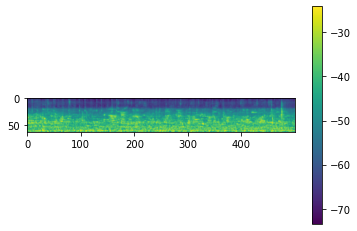

In [ ]:
plt.imshow(example[1].numpy()[:,:,0])
plt.colorbar()

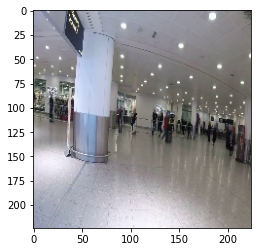

In [ ]:
plt.imshow(example[0].numpy()[0,:,:,:])